# **GNN_Energy.ipynb: Energy prediction for EIC Det2 KLM**
This notebook walks through the steps of loading data, training and testing a GNN for energy prediction tasks

In [1]:
# import matplotlib.pyplot as plot
import pandas as pd
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
from dgl.data import DGLDataset
import matplotlib.pyplot as plot
import numpy as np
import torch.nn as nn
import torch
import itertools
import dgl.data
import torch.nn.functional as F
from dgl.nn import GraphConv,SumPooling,GINConv,AvgPooling,MaxPooling
from dgl.dataloading import GraphDataLoader
from tqdm import tqdm
import matplotlib.pyplot as plot
from datetime import datetime as datetime
current_date = datetime.now().strftime("%B_%d")
from torch.utils.data.sampler import SubsetRandomSampler
from scipy.spatial import ConvexHull
from GNN_util import process_df_vectorized,create_directory,HitDataset,create_fast_edge_lists,visualize_detector_graph,GIN,train_GNN,test_GNN,calculate_bin_rmse

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


## **Load in Data**
The data is stored as pandas dataframes where each row is a hit in the detector

In [2]:
# constants
num_dfs = 40
kNN_k = 6
coneAngle = 40

In [3]:
inputDataPref_p1 = '/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/20k_total_events_May_01_mu-_0_5GeV_to_5GeV500events_run_1_' #muons / neutrons
inputDataPref_p2 = '/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/20k_total_events_May_01_pi+_0_5GeV_to_5GeV500events_run_1_' #pions / K_L
dfs = []
for i in range(num_dfs):
    try:
        new_df = pd.read_csv(f"{inputDataPref_p1}{i}.csv")
    except FileNotFoundError as e:
        # Skip files that failed for some reason...
        # I think these files fail due to DCC issues?
        print(f"skipping file #{i}...")
        continue
    new_df["file_idx"] = i
    dfs.append(new_df)
for j in range(num_dfs):
    try:
        new_df = pd.read_csv(f"{inputDataPref_p2}{j}.csv")
    except FileNotFoundError as e:
        # Skip files that failed for some reason...
        # I think these files fail due to DCC issues?
        print(f"skipping file #{j}...")
        continue
    new_df["file_idx"] = num_dfs + j #CANNOT USE SAME FILE IDX AS FROM PARTICLE 1 DATASET
    dfs.append(new_df)
if(len(dfs) > 1):
    data = pd.concat(dfs)
else:
    data = dfs[0]
    

skipping file #0...


In [46]:
class HitDataset(DGLDataset):
    def __init__(self, data, filter_events,connection_mode = "kNN",max_distance = 0.5,k = 6, function = 'momentum_reco'):
        self.data = data
        self.filter_events = filter_events
        self.max_distance = max_distance
        self.event_data = torch.tensor([])
        self.connection_mode = connection_mode
        self.function = function
        self.k = k
        self.dfs = []
        self.mass_dict = {
            130 : 0.497611,
            2112  : 0.939565,
            211 : 0.139570,
            -211 : 0.139570,
            13 : 0.10566
                         }
        self.PDG_label_dict = {
            13 : 1,
            211 : 0,
            -211 : 0,
            2112 : 1,
            130 : 0
        }
        super().__init__(name = "KLM_reco")
    def get_max_distance_edges(self,curr_event):
        x = curr_event['strip_x'].values
        y = curr_event['strip_y'].values

        # Create coordinate matrices
        x_diff = x[:, np.newaxis] - x[np.newaxis, :]  # Creates a matrix of all x differences
        y_diff = y[:, np.newaxis] - y[np.newaxis, :]  # Creates a matrix of all y differences

        # Compute distances in one go
        distances = np.sqrt(x_diff**2 + y_diff**2)

        # Create mask for valid edges (upper triangle only to avoid duplicates)
        upper_mask = (distances < self.max_distance) & (np.triu(np.ones_like(distances), k=1) > 0)

        # Get edge indices for upper triangle
        src_upper, dst_upper = np.where(upper_mask)

        # Create the bidirectional edges
        sources = np.concatenate([src_upper, dst_upper])
        destinations = np.concatenate([dst_upper, src_upper])
        return sources,destinations
    def get_knn_edges(self,curr_event):
        """ 
        Given x and y coordinates of nodes, compute edges for a k-NN graph.

        Args:
            x (numpy array): x-coordinates of nodes.
            y (numpy array): y-coordinates of nodes.
            k (int): Number of nearest neighbors.

        Returns:
            sources (numpy array): List of source nodes.
            destinations (numpy array): List of destination nodes.
        """
        x = curr_event['strip_x'].values
        y = curr_event['strip_y'].values
        n = len(x)

        # The first notation with "np.newaxis" is the same as tensor.unsqueeze(-1)
        # It puts each value in its own dimension, like
        # x = np.arrayy([[a],[b],[c]]), so size is (N,1) rather than (N)
        # The second notation (x[np.newaxis,:]) just puts the array in another array so that the size is (1,N
        # rather than (N)
        x_diff = x[:, np.newaxis] - x[np.newaxis, :]
        y_diff = y[:, np.newaxis] - y[np.newaxis, :]
        
        # distances has shape (N,N) - matrix where the diagonal is 0, each entry is the distance between
        # the ith (column idx) node and the jth (row idx) node
        distances = np.sqrt(x_diff**2 + y_diff**2)

        # Get the indices of the k nearest neighbors for each node (excluding self-connections)
        # argsort sorts each row by the distance and returns the sorted indices
        # We use the [:,1:k+1] to take the first k indices besides the lowest (which is the diagonal self connection)
        knn_indices = np.argsort(distances, axis=1)[:, 1:self.k+1]

        # Create source and destination lists
        sources = np.concatenate([np.repeat(np.arange(n), self.k),knn_indices.flatten()])
        destinations = np.concatenate([knn_indices.flatten(),np.repeat(np.arange(n), self.k)])

        return sources, destinations
        
    def process(self):
        events_group = self.data.groupby(["file_idx","event_idx"])
        self.labels = torch.tensor([])
        self.graphs = []
        it_idx = 0
        for event_idx in events_group.groups:
            curr_event = events_group.get_group(event_idx)
            nhits = len(curr_event)
            '''FIRST FILTER FOR EVENTS'''
            if(self.filter_events):
                ModifiedTrueID_unique = np.array(curr_event['ModifiedTrueID'].unique())
                valid_ModifiedTrueID_unique = ModifiedTrueID_unique[ModifiedTrueID_unique != -1]
                #skip events with multiple valid trueIDs
                if(len(valid_ModifiedTrueID_unique) > 1):
                    # In current implementation, this should be inaccessible if all other code correct
                    # This matters when simulating multiple primary particles in one event
                    print("Too many valid ModifiedTrueID, skipping...")
                    continue
            
                #skip events with no valid ModififiedTrueIDs
#                 if(len(valid_ModifiedTrueID_unique) == 0):
#                     print("No valid ModifiedTrueIDs, skipping...")
#                     continue
                # Remove rows that are hits outside of the cone
                curr_event = curr_event[curr_event.ModifiedTrueID != -1]
                nhits = len(curr_event)
            # Skip graphs with only 1 hit (or 0)
            if(nhits <2):
#                 print("only 1 hit, skipping...")
                continue;
            elif(nhits <self.k):
                sources = np.concatenate([np.repeat(np.arange(nhits),nhits),np.tile(np.arange(nhits),nhits)])
                destinations = np.concatenate([np.tile(np.arange(nhits),nhits),np.repeat(np.arange(nhits),nhits)])
            else:
                if(self.connection_mode == "max distance"):
                    sources, destinations = self.get_max_distance_edges(curr_event)
                elif(self.connection_mode == "kNN"):
                    sources, destinations = self.get_knn_edges(curr_event)
            g = dgl.graph((sources, destinations), num_nodes=nhits)
            #Want to predict energy
            try:
                mass = self.mass_dict[curr_event["truePID"].to_numpy()[0]]
            except Exception as e:
                truePID = curr_event["truePID"].to_numpy()[0]
                print(f"Exception: {e}")
                print(f"Particle with truePID of {truePID} not in dictionary. Skipping...")
                continue
            PDG = curr_event["truePID"].to_numpy()[0]
            momentum = curr_event["P"].to_numpy()[0]
            energy = np.sqrt(mass**2 + momentum**2)
            if(self.function == 'momentum_reco'):
                label = torch.tensor(energy)
            elif (self.function == 'PID'):
                label = torch.tensor(self.PDG_label_dict[PDG],dtype = torch.int64)
            strip_x = (curr_event["strip_x"].to_numpy() / 3000)
            strip_y = (curr_event["strip_y"].to_numpy() / 3000)
            radial_distance = torch.tensor(np.sqrt( strip_x** 2 + strip_y ** 2))
            '''VERSION LABEL INCLUDING EVENT FEATURES'''
            # Since this is the version with both SiPM in one hit/node, we have 2 times and charges
            # I hope that doing this will avoid making the NN learn that two hits at the same position are 
            # closely related
            feats = np.stack((
                strip_x,strip_y, radial_distance,
                curr_event["Time0"].to_numpy() / 5,
                curr_event["Charge0"].to_numpy(),
                curr_event["Time1"].to_numpy() / 5,
                curr_event["Charge1"].to_numpy(),
                curr_event["stave_idx"].to_numpy(),
                curr_event["layer_idx"].to_numpy(),
                curr_event["segment_idx"].to_numpy()
            ),axis = -1)
            g.ndata["feat"] = torch.tensor(feats)#.unsqueeze(-1)
            self.dfs.append(curr_event)
            # Sort hits by time

            # Basic features
            total_charge = curr_event['Charge1'].sum() + curr_event['Charge0'].sum()
            max_charge = max([curr_event['Charge1'].max(),curr_event['Charge0'].max()])
            n_hits = len(curr_event)

            # Spatial features
#             hit_coords = curr_event[['strip_x', 'strip_y']].values
            # Feature vector for this event
            event_features = torch.from_numpy(np.stack((label,
                total_charge,
                max_charge,
                n_hits
                ),axis = -1))
            if(self.labels.shape[0] == 0):
                self.labels = event_features
            else:
                self.labels = torch.vstack((self.labels,event_features))
            #add graph to dataset
            self.graphs.append(g)
            it_idx += 1
        self.dim_nfeats = self.graphs[0].ndata["feat"].shape[1]
        self.dim_event_feats = self.labels.shape[1] - 1
        self.labels = self.labels.clone().detach().float()

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

In [47]:
def process_df_vectorized(df, cone_angle_deg=45):
    # Grab positions to use as center of cone
    event_references = (
        df.groupby(['event_idx', 'file_idx'])
        .last()[['first_hit_strip_x', 'first_hit_strip_y']]
        .reset_index()
    )
    #Save angle of center/reference
    event_references['reference_angle'] = np.degrees(
        np.arctan2(event_references['first_hit_strip_y'],event_references['first_hit_strip_x'])
    )
    
    # Add these new columns to original df
    df = df.merge(event_references[['event_idx', 'file_idx', 'reference_angle']], 
                  on=['event_idx', 'file_idx'], how='left')
    
    # Calc angle of each hit and how far off from center
    df['hit_angle'] = np.degrees(np.arctan2(df['strip_y'], df['strip_x']))
    df['angle_diff'] = np.abs(df['hit_angle'] - df['reference_angle'])
    
    # Handle the wraparound at ±180 degrees
    df['angle_diff'] = np.minimum(df['angle_diff'], 360 - df['angle_diff'])
    
    # Label hits outside of the cone as noise (-1)
    df['ModifiedTrueID'] = df['trueID']
    df.loc[df['angle_diff'] > cone_angle_deg, 'ModifiedTrueID'] = -1
    
    # Drop intermediate columns if necessary
    return df

In [48]:
modified_df = process_df_vectorized(data, cone_angle_deg = coneAngle)    

filter_events_flag = True
connection_mode = "kNN"
dataset = HitDataset(modified_df,filter_events_flag,connection_mode = connection_mode,k = kNN_k, function = 'PID')

In [49]:
type(dataset[0][0])

dgl.heterograph.DGLGraph

In [7]:
len(dataset)

39032

## **Optionally, we can visualize any of the input graphs below**

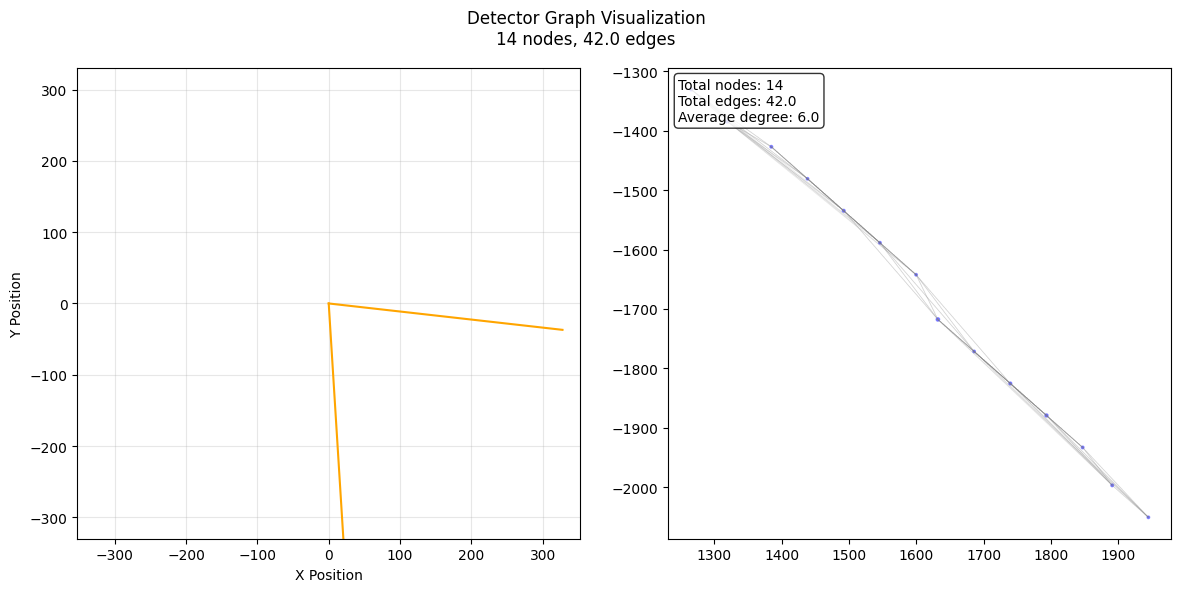

In [8]:
visualize_detector_graph(dataset,graph_idx = 6000)

## **Define dataloader**

We use a dataloader to make batching easier, and to randomly split test and train

In [9]:

# Assuming dataset[i][1] gives the label of the i-th graph
labels = torch.tensor([dataset[i][1][0] for i in range(len(dataset))])

# Get indices for each label
class_0_indices = torch.where(labels == 0)[0].tolist()
class_1_indices = torch.where(labels == 1)[0].tolist()

# Shuffle the indices for each class
np.random.shuffle(class_0_indices)
np.random.shuffle(class_1_indices)

# Determine split sizes
train_frac = 0.7
val_frac = 0.15

num_train_0 = int(len(class_0_indices) * train_frac)
num_val_0 = int(len(class_0_indices) * val_frac)

num_train_1 = int(len(class_1_indices) * train_frac)
num_val_1 = int(len(class_1_indices) * val_frac)

# Split the indices
train_indices = class_0_indices[:num_train_0] + class_1_indices[:num_train_1]
val_indices = (
    class_0_indices[num_train_0 : num_train_0 + num_val_0]
    + class_1_indices[num_train_1 : num_train_1 + num_val_1]
)
test_indices = class_0_indices[num_train_0 + num_val_0 :] + class_1_indices[num_train_1 + num_val_1 :]

# Shuffle each set to mix the labels
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)
np.random.shuffle(test_indices)

# Create samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create dataloaders
train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=20, drop_last=False
)

val_dataloader = GraphDataLoader(
    dataset, sampler=val_sampler, batch_size=20, drop_last=False
)

test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=20, drop_last=False
)


In [10]:
labels

tensor([1., 1., 1.,  ..., 0., 0., 0.])

## **Initialize the model and define the optimizer/criterion**

In [11]:
run_num = 1
geometry_type = 2

1. MLP hidden dim = 43
1. linear capacity = 3
1. linear layers = 7
1. conv layers = 1
1. lr = 4e-4

In [12]:
# Test:
hidden_dim = 32
linear_capacity = 5
early_stopping_limit = 4
n_conv_layers = 2
n_linear_layers = 7
lr = 1e-4

In [13]:
class GIN(nn.Module):
    def __init__(self, in_feats, h_feats,num_event_feats,n_conv_layers = 2, n_linear_layers = 7,linear_capacity = 5, num_classes=2,pooling_type = "avg"):
        super(GIN, self).__init__()
        # Define the MLP for the GINConv layers
        conv_list = []
        for i in range(n_conv_layers):
            first_in = (in_feats if i == 0 else h_feats)
            mlp = nn.Sequential(
                nn.Linear(first_in, h_feats),
                nn.ReLU(),
                nn.Linear(h_feats, h_feats)
            )
            conv_list.append(GINConv(mlp))
        self.conv_list = nn.ModuleList(conv_list)
        
        # Define the GINConv layers
        
        linear_list = []
        for i in range(n_linear_layers):
            if(i == 0):
                in_feats = h_feats + num_event_feats
#                 in_feats = h_feats
#                 in_feats = num_event_feats
                out_feats = pow(2,linear_capacity + (n_linear_layers // 2))
            elif(i == n_linear_layers - 1):
                in_feats = out_feats
                out_feats = num_classes
            else:
                in_feats = out_feats
                out_feats = out_feats // (2 if (i %2) else 1)
            linear_list.append(nn.Linear(in_feats,out_feats))
        linear_list.append(nn.Linear(out_feats,1))
        self.linear_list = nn.ModuleList(linear_list)
        
        # Graph pooling layer
        if(pooling_type == "avg"):
            self.pool = AvgPooling()
        elif(pooling_type == "sum"):
            self.pool = SumPooling()
        elif(pooling_type == "max"):
            self.pool = MaxPooling()
        else:
            print(f"Selected pooling type \"{pooling_type}\" not found. Resorting to default: AvgPooling")
            self.pool = AvgPooling()
        self.sig = nn.Sigmoid()

    def forward(self, g, in_feat,event_feats):
        # Apply the first GINConv layer
        
        h = in_feat
        hidden_reps = []
        for i in range(len(self.conv_list)):
            h = self.conv_list[i](g,h)
            h = F.relu(h)
            hidden_reps.append(self.pool(g,h))
        
        # Pool the graph-level representation - gives one array of length n_feats
        hg = self.pool(g, h)
        for i in range(len(hidden_reps)):
            hg += hidden_reps[i]
#         print(f"event feats 0: {event_feats[:,0]}")
#         total_feats = event_feats.float()#.unsqueeze(-1)
        total_feats = torch.cat((hg,event_feats),axis = 1).float()
#         total_feats = hg
        for i in range(len(self.linear_list) - 1):
            total_feats = self.linear_list[i](total_feats)
            total_feats = F.relu(total_feats)
            
        #No activation on last linear layer:
        total_feats = self.linear_list[-1](total_feats)
        total_feats = self.sig(total_feats)
        return total_feats

In [50]:
type(train_dataloader)

dgl.dataloading.dataloader.GraphDataLoader

In [14]:
model = GIN(dataset.dim_nfeats,hidden_dim,dataset.dim_event_feats,n_conv_layers = n_conv_layers, n_linear_layers = n_linear_layers,linear_capacity = linear_capacity)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion_energy = nn.MSELoss()
criterion_PDG = nn.BCELoss()

*Now we can actually train the model*

In [15]:
model_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/models/{current_date}/"

In [16]:
def train_GNN(model,optimizer,criterion, train_dataloader, val_dataloader, n_epochs,early_stopping_limit,frame_plot_path = "",model_path = "",log_status = True):
    create_directory(model_path)
    val_loss = []
    val_loss_all = []
    train_losses = []
    train_losses_all = []
    early_stopping_dict = {
            "lowest_loss" : -1,
            "best_model_path" : "",
            "num_upticks" : 0,
            "best_epoch": 0
    }

    for epoch in range(n_epochs):
        model.train()
        num_train_batches = 0
        epoch_train_losses = 0.0
        train_preds = torch.tensor([])
        train_truths = torch.tensor([])
        for batched_graph, labels_w_event_feats in train_dataloader:
            labels = labels_w_event_feats[:,0]
            event_feats = labels_w_event_feats[:,1:]
            pred = model(batched_graph, batched_graph.ndata["feat"].float(),event_feats)
            loss = criterion(pred, labels.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_train_losses+=loss.detach()
            train_losses_all.append(loss.detach())
            num_train_batches += 1
            train_preds = torch.cat([train_preds,pred.detach()])
            train_truths = torch.cat([train_truths,labels])
        # Average Accuracy and loss for the epoch
        this_epoch_loss = epoch_train_losses / num_train_batches
        train_losses.append(this_epoch_loss)
        # Testing phase
        model.eval()
        epoch_val_loss = 0.0
        num_val_batches = 0
        num_correct = 0
        num_total = 0
        val_preds = torch.tensor([])
        val_truths = torch.tensor([])
        with torch.no_grad():  # Disable gradients for evaluation
            for batched_graph, labels_w_event_feats in val_dataloader:
                labels = labels_w_event_feats[:,0]
                event_feats = labels_w_event_feats[:,1:]
                pred = model(batched_graph, batched_graph.ndata["feat"].float(),event_feats)
                # Calculate RMSE for this batch
                batch_loss = criterion(pred, labels.unsqueeze(-1))
                epoch_val_loss += batch_loss
                num_val_batches += 1
                val_loss_all.append(batch_loss)
                val_preds = torch.cat([val_preds,pred])
                val_truths = torch.cat([val_truths,labels])
                
                argmax_prediction = pred.squeeze() > 0.5
                num_correct += torch.sum(argmax_prediction == labels)
                num_total += len(labels)

        # Average RMSE for the test set
        epoch_val_loss /= num_val_batches
        epoch_acc = num_correct / num_total
        val_loss.append(epoch_val_loss)
        if(epoch %1 == 0):
            if(log_status):
                print(f"Epoch {epoch + 1}/{n_epochs} - Train loss:\t {this_epoch_loss:.4f}")
                print(f"Epoch {epoch + 1}/{n_epochs} - Validation Loss:\t {epoch_val_loss:.4f}")
                print(f"Epoch {epoch + 1}/{n_epochs} - Validation Accuracy:\t {epoch_acc:.4f}\n")
            if(frame_plot_path != ""):
                frame_fig, frame_axs = plot.subplots(1,1)
                frame_axs.plot([0,5],[0,5])
                frame_fig.suptitle("Test dataset results")
                frame_axs.scatter(val_truths,val_preds,alpha = 0.05,color = "red",label = "val")
    #             plot.scatter(train_truths,train_preds,alpha = 0.01,color = "blue",label = "train")
                frame_axs.set_xlabel("truths")
                frame_axs.set_ylabel("preds")
                frame_axs.text(3.1,1.3, f"Epoch #{epoch + 1}\nTrain, val loss: ({this_epoch_loss:.4f},{epoch_val_loss:.4f})")
                frame_fig.tight_layout()
                frame_fig.savefig(f"{frame_plot_path}epoch{epoch}.jpeg")
        
        if(epoch_val_loss.item() < early_stopping_dict["lowest_loss"] or early_stopping_dict["lowest_loss"] == -1):
            early_stopping_dict["lowest_loss"] = epoch_val_loss
            early_stopping_dict["best_model_path"] = f"{model_path}epoch_{epoch}.pth"
            early_stopping_dict["num_upticks"] = 0
            early_stopping_dict["best_epoch"] = epoch
            
            torch.save(model.state_dict(),early_stopping_dict["best_model_path"])
        elif(epoch_val_loss.item() > early_stopping_dict["lowest_loss"]):
            early_stopping_dict["num_upticks"] += 1
            if(log_status):
                print("Test loss increased, adding uptick")
        if(early_stopping_dict["num_upticks"] >= early_stopping_limit):
            # Stop training, load best model
            model.load_state_dict(torch.load(early_stopping_dict["best_model_path"]))
            torch.save(model.state_dict(),f"{model_path}best_model.pth")
            if(log_status):
                print("Stopping early, loading current model...")
            break
    return model, train_losses, val_loss, optimizer,early_stopping_dict["best_epoch"]

In [17]:
len(train_dataloader)

1367

In [18]:
n_epochs = 300
trained_model, train_losses, val_losses, optimizer,best_epoch = train_GNN(model,optimizer,criterion_PDG, train_dataloader, val_dataloader, n_epochs, early_stopping_limit, model_path = model_path)

Epoch 1/300 - Train loss:	 0.4291
Epoch 1/300 - Validation Loss:	 0.3769
Epoch 1/300 - Validation Accuracy:	 0.9105

Epoch 2/300 - Train loss:	 0.3624
Epoch 2/300 - Validation Loss:	 0.3412
Epoch 2/300 - Validation Accuracy:	 0.9276

Epoch 3/300 - Train loss:	 0.3314
Epoch 3/300 - Validation Loss:	 0.3263
Epoch 3/300 - Validation Accuracy:	 0.9219

Epoch 4/300 - Train loss:	 0.3074
Epoch 4/300 - Validation Loss:	 0.2922
Epoch 4/300 - Validation Accuracy:	 0.9373

Epoch 5/300 - Train loss:	 0.2873
Epoch 5/300 - Validation Loss:	 0.2730
Epoch 5/300 - Validation Accuracy:	 0.9409

Epoch 6/300 - Train loss:	 0.2700
Epoch 6/300 - Validation Loss:	 0.2567
Epoch 6/300 - Validation Accuracy:	 0.9419

Epoch 7/300 - Train loss:	 0.2563
Epoch 7/300 - Validation Loss:	 0.2467
Epoch 7/300 - Validation Accuracy:	 0.9392

Epoch 8/300 - Train loss:	 0.2395
Epoch 8/300 - Validation Loss:	 0.2281
Epoch 8/300 - Validation Accuracy:	 0.9464

Epoch 9/300 - Train loss:	 0.2279
Epoch 9/300 - Validation Loss:

## **Plot training and val loss on log scale**

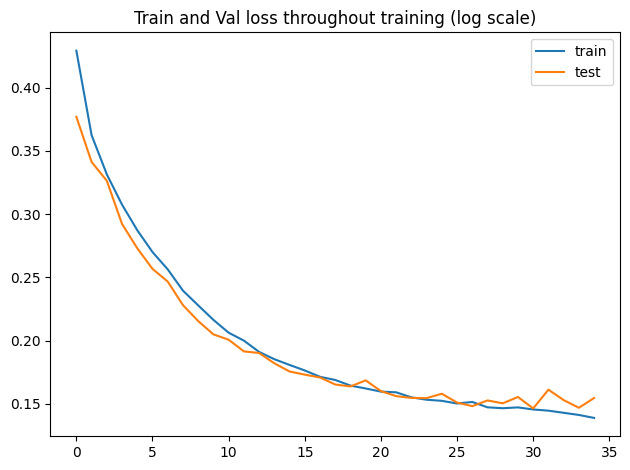

In [19]:
plot.plot(train_losses,label = "train")
plot.title("Train and Val loss throughout training (log scale)")
plot.plot(val_losses, label = "test")
plot.legend()
plot.tight_layout()

## **Evaluate model on test dataset**

Now we can check the RMSE and across the whole test dataset and visualize the result

In [40]:
def test_GNN(model, test_dataloader):
    truths_PDG = []
    preds_PDG = []
    preds_PDG_probs = []
    num_predictions = 0
    acc = 0
    with torch.no_grad():
        for batched_graph, labels in test_dataloader:
            graphs = dgl.unbatch(batched_graph)
            for i in range(len(graphs)):
                graph = graphs[i]
                labels_w_event_feats = labels[i]
                label_PDG = labels_w_event_feats[0].item()
                event_feats = labels_w_event_feats[1:].unsqueeze(0)
                pred = model(graph, graph.ndata["feat"].float(),event_feats).detach().numpy()[0][0]
                pred_PDG = int(pred >= 0.5)
                acc += pred_PDG == label_PDG
                num_predictions += 1

                preds_PDG.append(pred_PDG)
                preds_PDG_probs.append(pred)
                truths_PDG.append(label_PDG)
    accuracy = acc / num_predictions
    print(f"accuracy: {accuracy}")
    return truths_PDG, preds_PDG,preds_PDG_probs, accuracy

In [41]:
test_truths_PDG,test_preds_PDG,test_preds_PDG_probs, accuracy = test_GNN(trained_model, test_dataloader)

accuracy: 0.9557794092538843


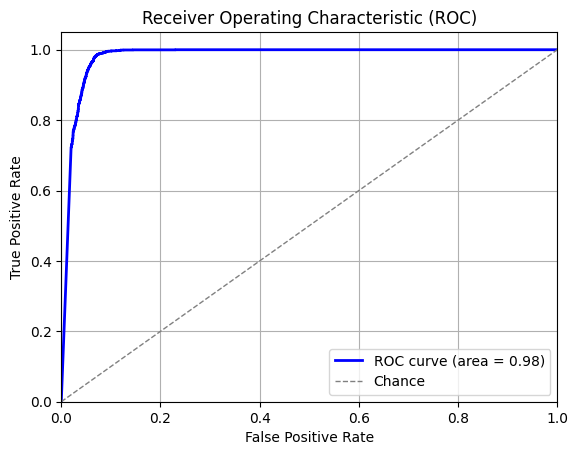

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(test_truths_PDG, test_preds_PDG_probs)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [52]:
int(test_truths_PDG[0])

1

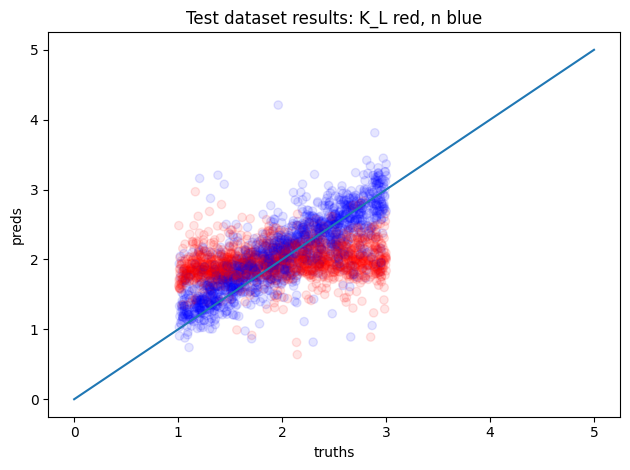

In [53]:
colors = []
for i in range(len(test_truths_PDG)):
    colors.append("red" if int(test_truths_PDG[i]) else "blue")
plot.plot([0,5],[0,5])
plot.title("Test dataset results: K_L red, n blue")
plot.scatter(test_truths_energy,test_preds_energy,alpha = 0.1,color = colors)
plot.xlabel("truths")
plot.ylabel("preds")
plot.tight_layout()


1. All event feats, No charge info: 0.1701
1. All event feats, No time info:  0.1299
1. No event feats, yes charge/time, avg pooling: 0.4533
1. No event feats, yes charge/time, sum pooling: 0.1824
1. No event feats, yes charge/time, max pooling: 0.2278
1. All event feats, yes charge/time, sum pooling: 0.1657
1. (Regular) All event feats, yes charge/time, avg pooling: 0.1208

#### feature comparison
All have same model, lr
1. kNN connecting with k = 6
1. MLP hidden dim = 32
1. early stopping limit = 3
1. lr = 1e-4
1. n_conv_layers = 2
1. n_linear_layers = 7
1. linear_capacity = 5
total num params: 

| Charge 0 | Charge 1 | Time 0 | Time 1 |  strip_x | strip_y  | radial_distance  | Total Charge | Max Charge | # hits | Pooling Type | **MSE**|
|----------|----------|--------|--------|----------|----------|------------------|--------------|------------|--------|--------------|--------|
| yes      |   yes    |   yes  |  yes   | yes      | yes      |         yes      |    yes       |  yes       |   yes  |  avg         | 0.1178 |
| yes      |   yes    |   yes  |  yes   | yes      | yes      |         no       |    yes       |  yes       |   yes  |  sum         | 0.1208 |
| yes      |   yes    |   no   |  no    | yes      | yes      |         no       |    yes       |  yes       |   yes  |  sum         | 0.1299 |
| yes      |   yes    |   yes  |  yes   | yes      | yes      |         no       |    yes       |  yes       |   yes  |  avg         | 0.1657 | 
| no       |   no     |   yes  |  yes   | yes      | yes      |         no       |    yes       |  yes       |   yes  |  sum         | 0.1701 |
| yes      |   yes    |   yes  |  yes   | yes      | yes      |         no       |    no        |  no        |   no   |  sum         | 0.1824 |
| yes      |   yes    |   yes  |  yes   | yes      | yes      |         no       |    no        |  no        |   no   |  avg         | 0.4533 |
| yes      |   yes    |   yes  |  yes   | yes      | yes      |         no       |    no        |  no        |   no   |  max         | 0.2278 |


#### Edge connecting
| Method |     k/max distance   | **MSE** |
|--------|----------------------|---------|
| max    | 100 (fully connected)| 0.1228  |
| max    | 30 (medium)          | 0.1661  |
| max    | 10 (sparse)          | 0.1515  |
| kNN    | 3 (low)              | 0.1203  |
| kNN    | 6 (med-low) (default)| 0.1135  |
| kNN    | 9 (medium high)      | 0.1217  |
| kNN    | 24 (high)            | 0.1437  |


#### New model params from hyperparam study
Trying new model with these params:
[I 2025-02-12 17:18:00,559] Trial 7 finished with value: 0.09892290830612183 and parameters: {'MLP_hidden_dim': 43, 'linear_capacity': 3, 'n_linear_layers': 7, 'n_conv_layers': 1, 'lr': 0.0004265157255271877}
1. MLP hidden dim = 43
1. linear capacity = 3
1. linear layers = 7
1. conv layers = 1
1. lr = 4e-4
  

# Binned RMSE

In [122]:
def calculate_bin_rmse(test_dataloader, model, bin_width=0.5, bin_min=1.0, bin_max=3.0):
    # Calculate the bin centers
    bin_centers = np.arange(bin_min + bin_width / 2, bin_max, bin_width)
    
    # Initialize dictionaries to store squared errors and counts per bin
    summed_sqe_per_bin = {bin_center: 0.0 for bin_center in bin_centers}
    bin_counts = {bin_center: 0 for bin_center in bin_centers}
    
    # Initialize lists to store predictions and truths
    preds = []
    truths = []
    
    # Process each batch of test data
    with torch.no_grad():
        for batched_graph, labels in test_dataloader:
            graphs = dgl.unbatch(batched_graph)
            for i in range(len(graphs)):
                graph = graphs[i]
                labels_w_event_feats = labels[i]
                label = labels_w_event_feats[0].item()
                event_feats = labels_w_event_feats[1:].unsqueeze(0)
                pred = model(graph, graph.ndata["feat"].float(),event_feats).detach().numpy()

                # Store predictions and truths
                preds.append(pred)
                truths.append(label)
                
                # Calculate the squared error
                squared_error = (pred - label) ** 2
                
                # Find the bin this label falls into and update corresponding squared error and count
                for bin_center in bin_centers:
                    bin_min_edge = bin_center - bin_width / 2
                    bin_max_edge = bin_center + bin_width / 2
                    if bin_min_edge <= label < bin_max_edge:
                        summed_sqe_per_bin[bin_center] += squared_error
                        bin_counts[bin_center] += 1
                        break  # Only assign to one bin
    
    # Calculate RMSE for each bin
    rmse_per_bin = {}
    for bin_center in bin_centers:
        if bin_counts[bin_center] > 0:  # Avoid division by zero if no predictions fall into the bin
            rmse_value = np.sqrt(summed_sqe_per_bin[bin_center] / bin_counts[bin_center])
            rmse_per_bin[bin_center] = float(rmse_value[0,0])  # Ensure it's a scalar
        else:
            rmse_per_bin[bin_center] = float('nan')  # Assign NaN if no predictions fall into the bin
    
    return rmse_per_bin

In [123]:
rmse_per_bin = calculate_bin_rmse(test_dataloader, model)

In [124]:
bin_centers = np.array(list(rmse_per_bin.keys()))
rmse = np.array(list(rmse_per_bin.values()))
rel_rmse = rmse / bin_centers

In [125]:
def func(x, A):
    return A / np.sqrt(x)
from scipy.optimize import curve_fit

params, cov = curve_fit(func, bin_centers, rel_rmse)
x_fit = np.linspace(1, 3, 100)
y_fit = func(x_fit, params)

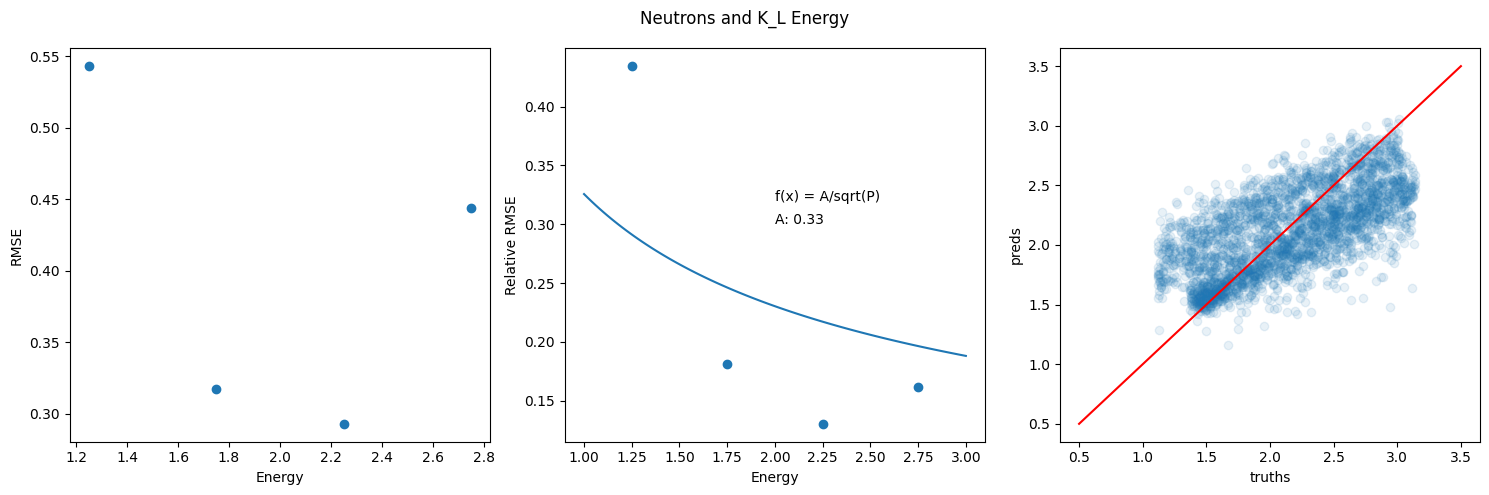

In [127]:
fig,axs = plot.subplots(1,3,figsize = (15,5))
fig.suptitle("Neutrons and K_L Energy")
axs[0].scatter(rmse_per_bin.keys(),rmse_per_bin.values())
axs[0].set(xlabel="Energy",ylabel = "RMSE")
axs[1].scatter(rmse_per_bin.keys(),np.array(list(rmse_per_bin.values())) / np.array(list(rmse_per_bin.keys())))
axs[1].plot(x_fit,y_fit)
axs[1].set(xlabel="Energy",ylabel = "Relative RMSE")
axs[1].text(2,0.3,f"A: {params[0]:.2f}")
axs[1].text(2,0.32,f"f(x) = A/sqrt(P)")
axs[2].scatter(test_truths,test_preds,alpha = 0.1)
axs[2].plot([0.5,3.5],[0.5,3.5],color = "red")
axs[2].set(xlabel = "truths",ylabel = "preds")
fig.tight_layout()
# plot.savefig(f"plots/GNN/run_{run_num}_RMSE_k_6.pdf")